In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import shutil
from glob import glob
import json
import math
import os
import cv2
import glob as gb
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications import densenet
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

In [3]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [4]:
import splitfolders
input_folder = "data/image"
output = "data/image/output/" 

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .3,)) 

Copying files: 508 files [00:02, 197.40 files/s]


In [5]:
code = {'jaundice':0, 'normal':1,
 }

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

32
354   354


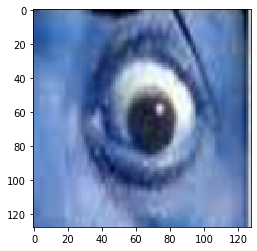

In [9]:

trainpath='data/image/output/train/'

X_train = []
y_train = []
for folder in  os.listdir(trainpath) : 
    files = gb.glob(pathname= str( trainpath + folder + '/*'))
    for file in files: 
        image = cv2.imread(file)
        plt.imshow(image)
        image_array = cv2.resize(image , (32,32))
        X_train.append(list(image_array))
        y_train.append(code[folder])
print(len(X_train[0]))
np.save('X_train',X_train)
np.save('y_train',y_train)
print(len(X_train),' ',len(y_train))


154   154


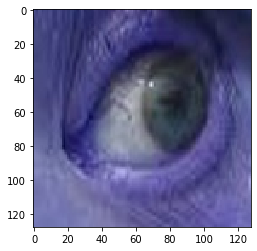

In [11]:

testpath= 'data/image/output/val/'

X_test = []
y_test = []
OGX = 3000
OGY = 1700
for folder in  os.listdir(testpath) : 
    files = gb.glob(pathname= str( testpath + folder + '/*'))
    for file in files: 
        image = cv2.imread(file)
        test_img = cv2.imread(file, cv2.IMREAD_COLOR) 
        test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
        test_image = test_img 
        test_img = cv2.resize(test_img, (32, 32))
        test_img = np.expand_dims(test_img, axis=0)
        prediction = model.predict(test_img)
        test_image = cv2.resize(test_image, (OGX, OGY))
plt.imshow(test_image)

        plt.imshow(image, cmap='gray')
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (32,32))
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)
print(len(X_test),' ',len(y_test))

In [8]:
loaded_X_train = np.load('X_train.npy')
loaded_X_test = np.load('X_test.npy')
loaded_y_train = np.load('y_train.npy')
loaded_y_test = np.load('y_test.npy')

In [9]:
X_train = loaded_X_train.reshape([-1, np.product((32,32,3))])
X_test = loaded_X_test.reshape([-1, np.product((32,32,3))])

In [10]:
y_train = loaded_y_train
y_test = loaded_y_test

In [11]:

from sklearn.utils import shuffle as shf
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [13]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# ANN

In [14]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.fit(X_train, y_train)
predictions = mlp.predict(X_test)
mlp_acc = accuracy_score(y_test, predictions)
mlp_prec = precision_score(y_test, predictions,average='weighted')
mlp_rec = recall_score(y_test, predictions,average='weighted')
mlp_f1 = f1_score(y_test, predictions,average='weighted')

In [15]:
storeResults('ANN',mlp_acc,mlp_prec,mlp_rec,mlp_f1)

# Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
predictions = dt.predict(X_test)
dt_acc = accuracy_score(y_test, predictions)
dt_prec = precision_score(y_test, predictions,average='weighted')
dt_rec = recall_score(y_test, predictions,average='weighted')
dt_f1 = f1_score(y_test, predictions,average='weighted')

In [17]:
storeResults('Decision Tree',dt_acc,dt_prec,dt_rec,dt_f1)

# Voting Classifier

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()

eclf1 = VotingClassifier(estimators=[('dt', clf1),('rf', clf2)], voting='soft')
eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_test)
vot_acc = accuracy_score(y_test, predictions)

vot_prec = precision_score(y_test, predictions,average='weighted')
vot_rec = recall_score(y_test, predictions,average='weighted')
vot_f1 = f1_score(y_test, predictions,average='weighted')

In [19]:
storeResults('Voting Classifier',vot_acc,vot_prec,vot_rec,vot_f1)

DL

In [20]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [21]:
train_path = "data/train"
test_path = "data/test"

In [22]:
IMAGE_SIZE = [128,128]

In [23]:


train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)


test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
train_set = train_datagen.flow_from_directory(trainpath,
                                              target_size=(128,128),
                                              batch_size=32,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(testpath,
                                            target_size=(128,128),
                                            batch_size=32,
                                            class_mode='categorical')

Found 354 images belonging to 3 classes.
Found 154 images belonging to 3 classes.


In [25]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [27]:
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate

# CNN

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [39]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(128, 128, 3)))
model2.add(MaxPool2D(strides=3))
model2.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model2.add(MaxPool2D(strides=3))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(84, activation='relu'))
model2.add(Dense(3, activation='softmax'))

In [40]:
model2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

In [41]:
model2.build()
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 39, 39, 48)        38448     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 48)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8112)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2076928   
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

In [42]:
hist2 = model2.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/20
12/12 [==============================] - ETA: 9s - loss: 1.1836 - accuracy: 0.0000e+00 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+ - ETA: 4s - loss: 1.0432 - accuracy: 0.3235 - f1_m: 0.1746 - precision_m: 0.1774 - recall_m: 0.1719               - ETA: 3s - loss: 0.9406 - accuracy: 0.3636 - f1_m: 0.1164 - precision_m: 0.1183 - recall_m: 0.11 - ETA: 3s - loss: 0.8666 - accuracy: 0.4388 - f1_m: 0.2381 - precision_m: 0.2419 - recall_m: 0.23 - ETA: 2s - loss: 0.8500 - accuracy: 0.4462 - f1_m: 0.2842 - precision_m: 0.2873 - recall_m: 0.28 - ETA: 2s - loss: 0.8173 - accuracy: 0.4691 - f1_m: 0.3321 - precision_m: 0.3362 - recall_m: 0.32 - ETA: 1s - loss: 0.8121 - accuracy: 0.4742 - f1_m: 0.3561 - precision_m: 0.3596 - recall_m: 0.35 - ETA: 1s - loss: 0.7903 - accuracy: 0.4867 - f1_m: 0.3819 - precision_m: 0.3850 - recall_m: 0.37 - ETA: 1s - loss: 0.7736 - accuracy: 0.5310 - f1_m: 0.4332 - precision_m: 0.4359 - recall_m: 0.43 - ETA: 0s - loss: 0.7685 - accuracy:

12/12 [==============================] - ETA: 7s - loss: 0.3108 - accuracy: 0.8125 - f1_m: 0.8125 - precision_m: 0.8125 - recall_m: 0.81 - ETA: 5s - loss: 0.3518 - accuracy: 0.8125 - f1_m: 0.8125 - precision_m: 0.8125 - recall_m: 0.81 - ETA: 4s - loss: 0.2913 - accuracy: 0.8438 - f1_m: 0.8437 - precision_m: 0.8438 - recall_m: 0.84 - ETA: 4s - loss: 0.2532 - accuracy: 0.8672 - f1_m: 0.8672 - precision_m: 0.8672 - recall_m: 0.86 - ETA: 3s - loss: 0.2500 - accuracy: 0.8813 - f1_m: 0.8812 - precision_m: 0.8813 - recall_m: 0.88 - ETA: 3s - loss: 0.2284 - accuracy: 0.9010 - f1_m: 0.9010 - precision_m: 0.9010 - recall_m: 0.90 - ETA: 2s - loss: 0.2372 - accuracy: 0.8973 - f1_m: 0.8973 - precision_m: 0.8973 - recall_m: 0.89 - ETA: 2s - loss: 0.2407 - accuracy: 0.8945 - f1_m: 0.8945 - precision_m: 0.8945 - recall_m: 0.89 - ETA: 1s - loss: 0.2323 - accuracy: 0.8993 - f1_m: 0.8993 - precision_m: 0.8993 - recall_m: 0.89 - ETA: 1s - loss: 0.2249 - accuracy: 0.9062 - f1_m: 0.9062 - precision_m: 0.906

In [43]:
dl_acc = hist2.history["val_accuracy"][13]
dl_prec = hist2.history["val_precision_m"][13]
dl_rec = hist2.history["val_recall_m"][13]
dl_f1 = hist2.history["val_f1_m"][13]

storeResults('CNN',dl_acc,dl_prec,dl_rec,dl_f1)

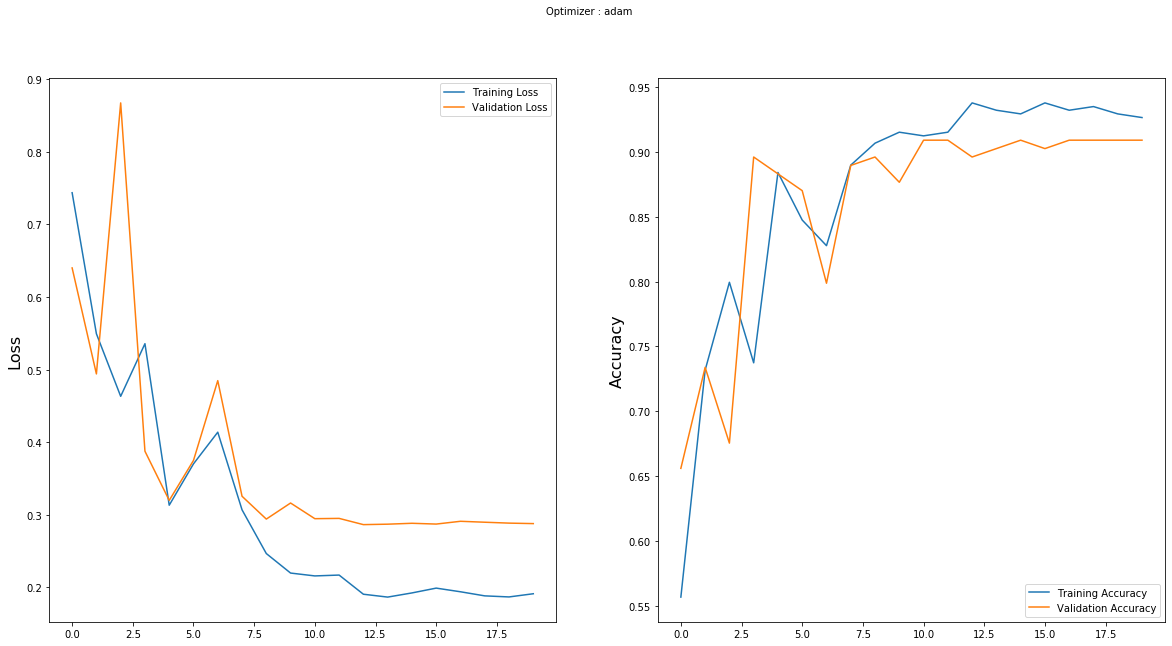

In [44]:
import matplotlib.pyplot as plt

x=hist2
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Xception

In [46]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Activation, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

In [50]:
base_model = Xception(input_shape = IMAGE_SIZE + [3],weights='xception_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False )

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

predictions = Dense(3, activation='softmax')(x)


model3 = Model(inputs=base_model.input, outputs=predictions)
model3.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

block9_sepconv1 (SeparableConv2 (None, 8, 8, 728)    536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 8, 8, 728)    2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 8, 8, 728)    0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 8, 8, 728)    536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv2_bn (BatchNormal (None, 8, 8, 728)    2912        block9_sepconv2[0][0]            
__________________________________________________________________________________________________
block9_sep

In [51]:
hist3 = model3.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/20
12/12 [==============================] - ETA: 1:50 - loss: 1.1668 - accuracy: 0.2188 - f1_m: 0.0571 - precision_m: 0.3333 - recall_m: 0.03 - ETA: 45s - loss: 1.0612 - accuracy: 0.3438 - f1_m: 0.2327 - precision_m: 0.4608 - recall_m: 0.1719 - ETA: 41s - loss: 1.0448 - accuracy: 0.4792 - f1_m: 0.1943 - precision_m: 0.6405 - recall_m: 0.135 - ETA: 36s - loss: 1.0021 - accuracy: 0.5469 - f1_m: 0.2457 - precision_m: 0.7304 - recall_m: 0.164 - ETA: 32s - loss: 0.9517 - accuracy: 0.5688 - f1_m: 0.2902 - precision_m: 0.7310 - recall_m: 0.200 - ETA: 22s - loss: 0.9474 - accuracy: 0.5679 - f1_m: 0.3530 - precision_m: 0.7758 - recall_m: 0.250 - ETA: 20s - loss: 0.8927 - accuracy: 0.5979 - f1_m: 0.3849 - precision_m: 0.7721 - recall_m: 0.281 - ETA: 16s - loss: 0.8465 - accuracy: 0.6195 - f1_m: 0.4153 - precision_m: 0.7809 - recall_m: 0.308 - ETA: 13s - loss: 0.8302 - accuracy: 0.6589 - f1_m: 0.4540 - precision_m: 0.7956 - recall_m: 0.347 - ETA: 8s - loss: 0.8163 - accuracy: 0.6690 - f1_

12/12 [==============================] - ETA: 1:03 - loss: 0.0528 - accuracy: 1.0000 - f1_m: 0.9841 - precision_m: 1.0000 - recall_m: 0.96 - ETA: 54s - loss: 0.0991 - accuracy: 0.9688 - f1_m: 0.9608 - precision_m: 0.9688 - recall_m: 0.9531 - ETA: 47s - loss: 0.0791 - accuracy: 0.9688 - f1_m: 0.9635 - precision_m: 0.9688 - recall_m: 0.958 - ETA: 29s - loss: 0.0785 - accuracy: 0.9694 - f1_m: 0.9726 - precision_m: 0.9766 - recall_m: 0.968 - ETA: 27s - loss: 0.0753 - accuracy: 0.9615 - f1_m: 0.9686 - precision_m: 0.9748 - recall_m: 0.962 - ETA: 25s - loss: 0.0749 - accuracy: 0.9691 - f1_m: 0.9711 - precision_m: 0.9790 - recall_m: 0.963 - ETA: 22s - loss: 0.0680 - accuracy: 0.9742 - f1_m: 0.9753 - precision_m: 0.9820 - recall_m: 0.968 - ETA: 18s - loss: 0.0669 - accuracy: 0.9735 - f1_m: 0.9745 - precision_m: 0.9803 - recall_m: 0.968 - ETA: 13s - loss: 0.0814 - accuracy: 0.9651 - f1_m: 0.9669 - precision_m: 0.9721 - recall_m: 0.961 - ETA: 9s - loss: 0.0764 - accuracy: 0.9690 - f1_m: 0.9702 -

In [52]:
dl_acc = hist3.history["val_accuracy"][19]
dl_prec = hist3.history["val_precision_m"][19]
dl_rec = hist3.history["val_recall_m"][19]
dl_f1 = hist3.history["val_f1_m"][19]

storeResults('Xception',dl_acc,dl_prec,dl_rec,dl_f1)

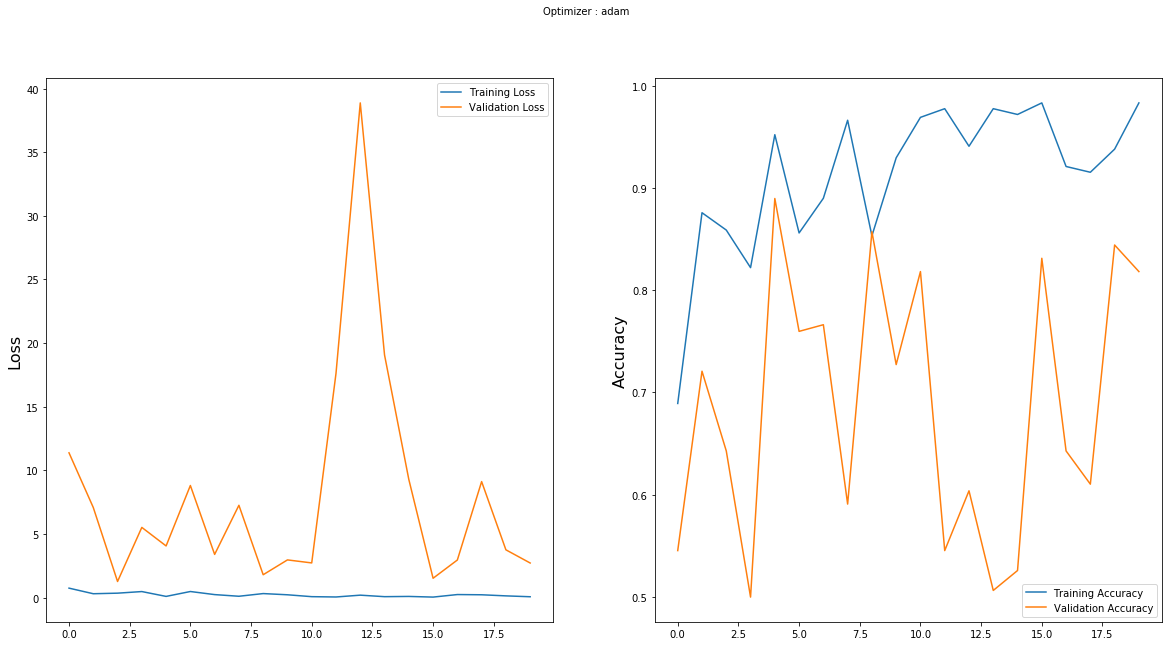

In [53]:
import matplotlib.pyplot as plt

x=hist3
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Comparison

In [54]:

result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'Precision': precision,
                        'Recall'   : recall,
                        'F1-Score': f1score,
                      })

In [55]:
result

,ML Model,Accuracy,Precision,Recall,F1-Score
0,ANN,0.695,0.786,0.695,0.672
1,Decision Tree,0.695,0.695,0.695,0.695
2,Voting Classifier,0.714,0.715,0.714,0.714
3,CNN,0.903,0.905,0.905,0.905
4,Xception,0.818,0.819,0.819,0.819


# Modelling

In [56]:
import pickle
pickle.dump(eclf1,open('model.pkl','wb'))

In [57]:
model3.save('model.h5')

# Graph

In [58]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

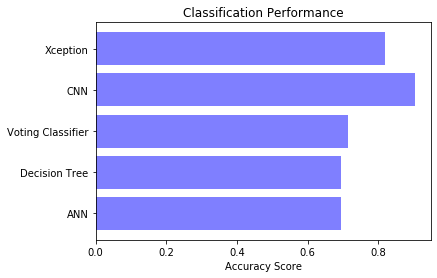

In [59]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

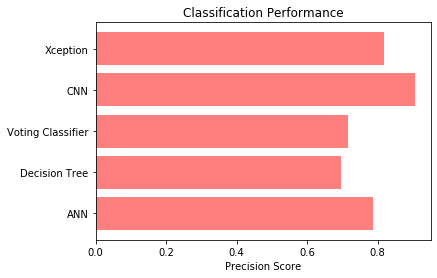

In [60]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

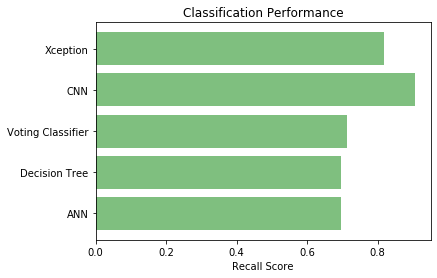

In [61]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='green')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

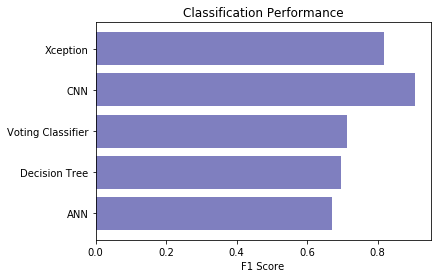

In [62]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()